In [319]:
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings("ignore")

In [320]:
df = pd.read_csv('stroke.csv')

In [321]:
# Pre-processing


In [322]:
# Remove Id Field

In [323]:
df = df.drop("id", axis=1)

In [324]:
# Dropping all rows with Nan Values

In [325]:
df = df.dropna()

In [326]:
df['stroke'].value_counts()

0    4700
1     209
Name: stroke, dtype: int64

In [327]:
# Changing gender, ever-married, work_type, Residence_type, smoking_status to one hot notation
gender = pd.get_dummies(df['gender'], prefix='gender')
df['gender_Female'] = gender['gender_Female']
df['gender_Male'] = gender['gender_Male']
df['gender_Other'] = gender['gender_Other']
df = df.drop("gender", axis=1)
residence = pd.get_dummies(df['Residence_type'], prefix='Residence_type')
df['Residence_type_Rural'] = residence['Residence_type_Rural']
df['Residence_type_Urban'] = residence['Residence_type_Urban']
df = df.drop("Residence_type", axis=1)
ever_married = pd.get_dummies(df['ever_married'], prefix='ever_married')
df['ever_married_No'] = ever_married['ever_married_No']
df['ever_married_Yes'] = ever_married['ever_married_Yes']
df = df.drop("ever_married", axis=1)
smoking_status = pd.get_dummies(df['smoking_status'], prefix='smoking_status')
df['smoking_status_Unknown'] = smoking_status['smoking_status_Unknown']
df['smoking_status_formerly smoked'] = smoking_status['smoking_status_formerly smoked']
df['smoking_status_never smoked'] = smoking_status['smoking_status_never smoked']
df['smoking_status_smokes'] = smoking_status['smoking_status_smokes']
df = df.drop("smoking_status", axis=1)
work_type = pd.get_dummies(df['work_type'], prefix='work_type')
df['work_type_Govt_job'] = work_type['work_type_Govt_job']
df['work_type_Never_worked'] = work_type['work_type_Never_worked']
df['work_type_Private'] = work_type['work_type_Private']
df['work_type_Self-employed'] = work_type['work_type_Self-employed']
df['work_type_children'] = work_type['work_type_children']
df = df.drop("work_type", axis=1)

In [328]:
# Create X and Y dataset

In [329]:
Y_df = df['stroke']
X_df = df.drop("stroke", axis=1)


In [330]:
oversample = RandomOverSampler(sampling_strategy=0.30)
X_df, Y_df = oversample.fit_resample(X_df, Y_df)
Y_df.value_counts()
#X_df.shape

0    4700
1    1410
Name: stroke, dtype: int64

In [331]:
#Y_df = pd.DataFrame(Y_df)
#Y_df['stroke'].value_counts()

In [332]:
# Neural Network Load Data -- ALL FEATURES
(X_train, X_test, y_train, y_test) = train_test_split(X_df, Y_df, test_size=0.30)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
#displays the amount of samples in each dataset
print('Samples in Train Set:', len(X_train))
print('Samples in Test Set:', len(X_test))


#Displays perccent of each class
print('Initial Dataset')
print('Percent "stroke":', y_train.sum()/len(y_train))
print('Balanced Dataset')
print('Percent "stroke":', y_bal.sum()/len(y_bal))

Samples in Train Set: 4277
Samples in Test Set: 1833
Initial Dataset
Percent "stroke": 0.23521159691372456
Balanced Dataset
Percent "stroke": 0.5


In [333]:
# Convert data to torch tensors
#X_train = X_train.to_numpy()
#y_train = y_bal
#X_train = X_bal

y_train = np.array(y_train)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [334]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

In [335]:
# Create Dataloader
train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)

test_data = Data(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, shuffle=True)

In [336]:
# Design Neural Network
n_input = 21
n_hidden = 8
n_out = 1

model = nn.Sequential(nn.Linear(n_input, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_out),
                      nn.Sigmoid())

In [337]:
# Data Set is imbalanced so need to add weights for classes to loss function
# Positive Weight = 1 - (209/4909) = 0.9575
# Negative Weight = 1 - (4700/4909) = 0.0426
# class_weights = torch.tensor([0.10])

learning_rate = 0.01

loss_fn = nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [338]:
# Train Model
num_epochs = 100
loss_values = []


for epoch in range(num_epochs):
    for X, y in train_dataloader:
        # zero the parameter gradients
        optimizer.zero_grad()
       
        # forward + backward + optimize
        pred = model(X)
        loss = loss_fn(pred, y.unsqueeze(-1))
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()

print("Training Complete")

Training Complete


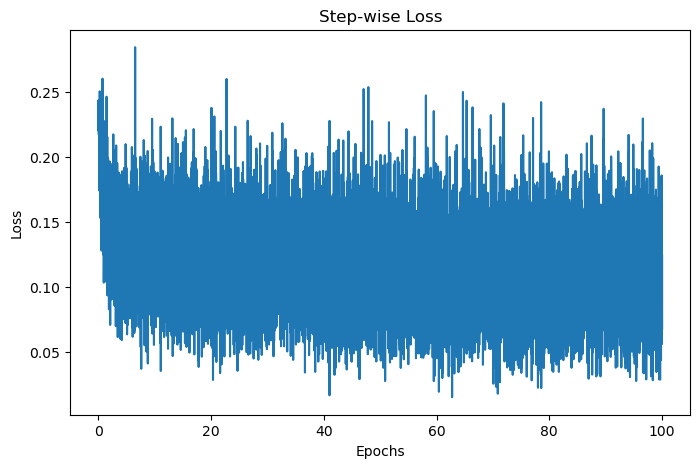

In [339]:
# Show Loss
step = np.linspace(0, 100, 13400)

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [340]:
# Accuracy Calculation
y_pred = []
y_test = []
with torch.no_grad():
    for X, y in test_dataloader:
        outputs = model(X)
        predicted = np.where(outputs < 0.5, 0, 1)
        predicted = list(itertools.chain(*predicted))
        y_pred.append(predicted)
        y_test.append(y)
        total += y.size(0)
        correct += (predicted == y.numpy()).sum().item()

print(f'Accuracy of the network on the 3300 test instances: {100 * correct // total}%')

Accuracy of the network on the 3300 test instances: 81%


In [341]:
# Classification Report
y_pred = list(itertools.chain(*y_pred))
y_test = list(itertools.chain(*y_test))


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.91      0.89      1429
         1.0       0.64      0.56      0.60       404

    accuracy                           0.83      1833
   macro avg       0.76      0.73      0.75      1833
weighted avg       0.83      0.83      0.83      1833



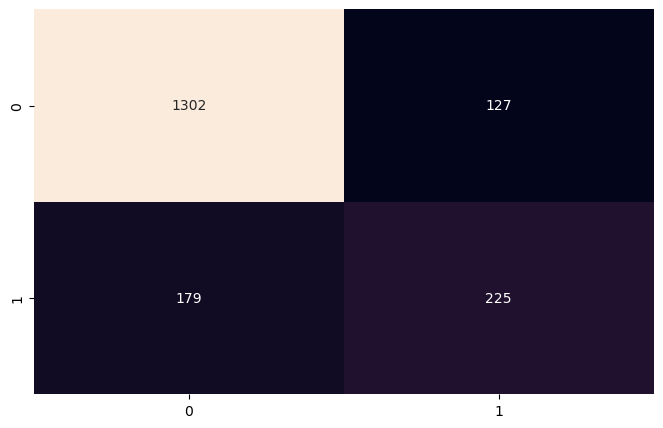

In [342]:
# Confusion Matrix
cf_matrix = confusion_matrix(y_test, y_pred)

plt.subplots(figsize=(8, 5))

sns.heatmap(cf_matrix, annot=True, cbar=False, fmt="g")

plt.show()

In [383]:
# Dropping all Lifestyle Features
X_df_nl = df
X_df_nl = X_df_nl.drop("Residence_type_Rural", axis=1)
X_df_nl = X_df_nl.drop("Residence_type_Urban", axis=1)
X_df_nl = X_df_nl.drop("ever_married_No", axis=1)
X_df_nl = X_df_nl.drop("ever_married_Yes", axis=1)
X_df_nl = X_df_nl.drop("smoking_status_Unknown", axis=1)
X_df_nl = X_df_nl.drop("smoking_status_formerly smoked", axis=1)
X_df_nl = X_df_nl.drop("smoking_status_never smoked", axis=1)
X_df_nl = X_df_nl.drop("smoking_status_smokes", axis=1)
X_df_nl = X_df_nl.drop("work_type_Govt_job", axis=1)
X_df_nl = X_df_nl.drop("work_type_Never_worked", axis=1)
X_df_nl = X_df_nl.drop("work_type_Private", axis=1)
X_df_nl = X_df_nl.drop("work_type_Self-employed", axis=1)
X_df_nl = X_df_nl.drop("work_type_children", axis=1)
X_df_nl.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other
0,67.0,0,1,228.69,36.6,1,0,1,0
2,80.0,0,1,105.92,32.5,1,0,1,0
3,49.0,0,0,171.23,34.4,1,1,0,0
4,79.0,1,0,174.12,24.0,1,1,0,0
5,81.0,0,0,186.21,29.0,1,0,1,0


In [384]:
Y_df_nl = X_df_nl['stroke']
X_df_nl = X_df_nl.drop("stroke", axis=1)
X_df_nl.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other
0,67.0,0,1,228.69,36.6,0,1,0
2,80.0,0,1,105.92,32.5,0,1,0
3,49.0,0,0,171.23,34.4,1,0,0
4,79.0,1,0,174.12,24.0,1,0,0
5,81.0,0,0,186.21,29.0,0,1,0


In [385]:
oversample = RandomOverSampler(sampling_strategy=0.30)
X_df_nl, Y_df_nl = oversample.fit_resample(X_df_nl, Y_df_nl)
X_df_nl.head()
X_df_nl.shape

(6110, 8)

In [386]:
# Neural Network Load Data -- ALL FEATURES
(X_train, X_test, y_train, y_test) = train_test_split(X_df_nl, Y_df_nl, test_size=0.30)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
#displays the amount of samples in each dataset
print('Samples in Train Set:', len(X_train))
print('Samples in Test Set:', len(X_test))


#Displays perccent of each class
print('Initial Dataset')
print('Percent "stroke":', y_train.sum()/len(y_train))
print('Balanced Dataset')
print('Percent "stroke":', y_bal.sum()/len(y_bal))

Samples in Train Set: 4277
Samples in Test Set: 1833
Initial Dataset
Percent "stroke": 0.22726209960252514
Balanced Dataset
Percent "stroke": 0.5


In [387]:
# Convert data to torch tensors
#X_train = X_train.to_numpy()
#y_train = y_bal
#X_train = X_bal

y_train = np.array(y_train)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [388]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

In [389]:
# Create Dataloader
train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)

test_data = Data(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, shuffle=True)

In [390]:
# Design Neural Network
n_input = 8
n_hidden = 6
n_out = 1

model = nn.Sequential(nn.Linear(n_input, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_out),
                      nn.Sigmoid())

In [391]:
# Data Set is imbalanced so need to add weights for classes to loss function
# Positive Weight = 1 - (209/4909) = 0.9575
# Negative Weight = 1 - (4700/4909) = 0.0426
# class_weights = torch.tensor([0.10])

learning_rate = 0.01

loss_fn = nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [392]:
# Train Model
num_epochs = 100
loss_values = []


for epoch in range(num_epochs):
    for X, y in train_dataloader:
        # zero the parameter gradients
        optimizer.zero_grad()
       
        # forward + backward + optimize
        pred = model(X)
        loss = loss_fn(pred, y.unsqueeze(-1))
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()

print("Training Complete")

Training Complete


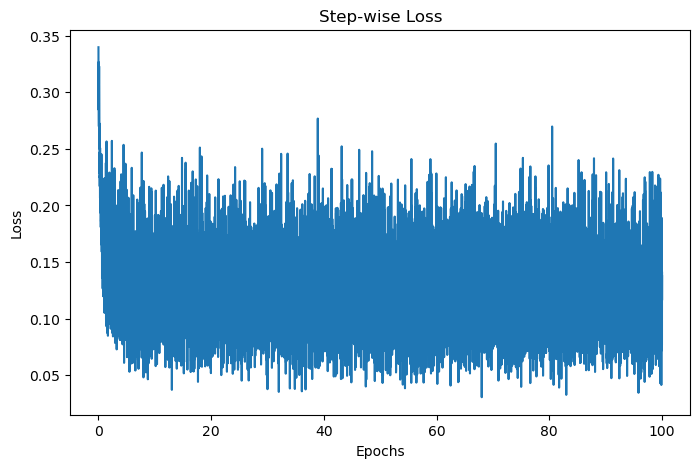

In [393]:
# Show Loss
step = np.linspace(0, 100, 13400)

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [394]:
# Accuracy Calculation
y_pred = []
y_test = []
with torch.no_grad():
    for X, y in test_dataloader:
        outputs = model(X)
        predicted = np.where(outputs < 0.5, 0, 1)
        predicted = list(itertools.chain(*predicted))
        y_pred.append(predicted)
        y_test.append(y)
        total += y.size(0)
        correct += (predicted == y.numpy()).sum().item()

print(f'Accuracy of the network on the 3300 test instances: {100 * correct // total}%')

Accuracy of the network on the 3300 test instances: 81%


In [395]:
# Classification Report
y_pred = list(itertools.chain(*y_pred))
y_test = list(itertools.chain(*y_test))


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88      1395
         1.0       0.64      0.53      0.58       438

    accuracy                           0.82      1833
   macro avg       0.75      0.72      0.73      1833
weighted avg       0.81      0.82      0.81      1833



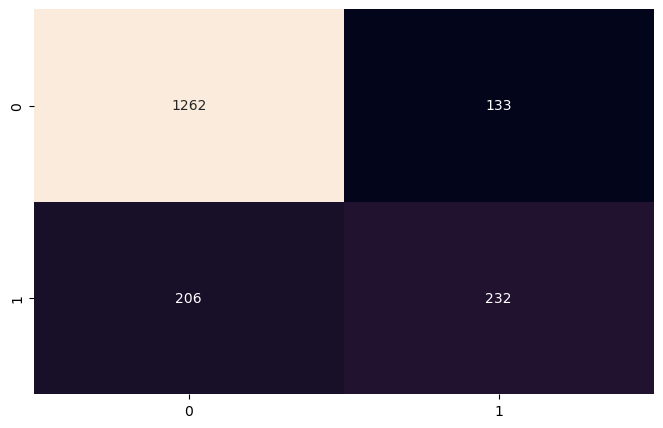

In [396]:
# Confusion Matrix
cf_matrix = confusion_matrix(y_test, y_pred)

plt.subplots(figsize=(8, 5))

sns.heatmap(cf_matrix, annot=True, cbar=False, fmt="g")

plt.show()